<a href="https://colab.research.google.com/github/peppefdf/Generate_stops/blob/main/Generate_stops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Coordinates of maximum density point:  [43.32254    -1.97116863]
Coordinates of maximum density point:  [43.09290829 -2.31824544]
Coordinates of maximum density point:  [43.33821745 -1.7930557 ]
Coordinates of maximum density point:  [43.2854063  -2.17596084]
Coordinates of maximum density point:  [43.18302098 -2.47301982]
Coordinates of maximum density point:  [43.18653997 -2.05309631]
Coordinates of maximum density point:  [43.04829359 -2.20167626]
Coordinates of maximum density point:  [43.31307597 -1.90104872]
Coordinates of maximum density point:  [43.26955813 -2.01740199]
Coordinates of maximum density point:  [43.03484522 -2.4140104 ]
Coordinates of maximum density point:  [43.3244914  -1.93035464]
Coordinates of maximum density point:  [43.13728237 -2.07440269]
Coordinates of maximum density point:  [43.30408204 -2.37612476]
Coordinates of maximum density point:  [43.11161266 -2.41275267]
Coordinates of maximum density point:  [43.26601296 -1.97665759]
Coordinates of maximum de

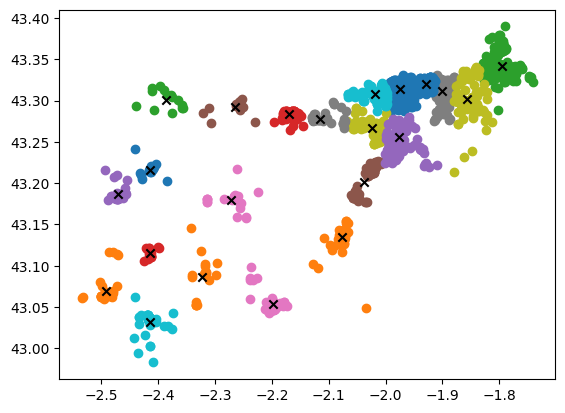

In [26]:
#%pip install osmnx

import numpy as np
import osmnx as ox
import pandas as pd
import folium
import random
import sklearn
from sklearn.cluster import KMeans
import geopy.distance
from scipy import stats

from matplotlib import pyplot as plt
from google.colab import drive

#n_skip = 10
n_clusters = 22
#dist_tol = 1000 # distance tolerance for bus_stop from cluster center (in meters)

workers_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/Accessibility_Map/workers_eskuzaitzeta_12_02_2024.csv", encoding='latin-1')
stops_df = df1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CSL_GIPUZKOA/GTFS_files_bus_stops_12_02_2024/all_stops_12_02_2024.csv", encoding='latin-1')

#lat_lon = workers_df[['O_lat', 'O_long']][::n_skip] # take every n elements
workers_lat_lon = workers_df[['O_lat', 'O_long']].values.tolist()

stops_lat_lon = stops_df[['stop_lat','stop_lon']].to_numpy()


ori_lat = 43.13525255625577
ori_lon = -2.080054227169231


model = KMeans(n_clusters=n_clusters)
# fit the model
model.fit(workers_lat_lon)
# assign a cluster to each example
yhat = model.predict(workers_lat_lon)

# retrieve unique clusters
clusters = np.unique(yhat)
centers = np.array(model.cluster_centers_)


cont_cluster = 0
highDens_points = []
for cluster in clusters:
 X = []
 Y = []
 # get row indexes for samples with this cluster
 row_ix = np.where(yhat == cluster)
 # create scatter of these samples
 dist = []
 for i_cl in range(len(row_ix[0])):

     # calculate Euclidean distance of each point from cluster center
     #d = sum((p-q)**2 for p, q in zip(centers[cont_cluster], workers_lat_lon[row_ix[0][i_cl]]))**.5
     #dist.append(d)
     X.append(workers_lat_lon[row_ix[0][i_cl]][0])
     Y.append(workers_lat_lon[row_ix[0][i_cl]][1])

 #centers_ref = np.tile(centers[cont_cluster],(len(row_ix[0]),1)) # generate replicas of cluster center coords.
 #dist = [geopy.distance.geodesic((p[0],p[1]), (q[0],q[1])).km for p, q in zip(centers_ref, np.array(workers_lat_lon)[row_ix[0]])]

 # find index of the point with minimum distance from cluster center
 #index_min = np.argmin(dist)
 # assign closest point to cluster center: this tries to avoid the cluster center to fall in the middle of nowhere
 #centers[cont_cluster][0] = workers_lat_lon[row_ix[0][index_min]][0]
 #centers[cont_cluster][1] = workers_lat_lon[row_ix[0][index_min]][1]

 xy = np.vstack([X,Y])
 kde = stats.gaussian_kde(xy)
 density = kde(xy)
 xymax = xy.T[np.argmax(density)]
 highDens_points.append(xymax)
 print('Coordinates of maximum density point: ', xymax)

 cont_cluster+=1
 plt.scatter(Y,X)

# plot centers
#centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
plt.show()

"""
tags = {'highway':'bus_stop',
        'bus':'yes',
        'unsigned':'yes',
        'public_transport':['stop_position','platform']}
"""
"""
tags = {'highway':'bus_stop',
        'bus':'yes'}
"""

bus_stops = []
center_ind = []
for i in range(len(centers)):
    #lat = centers[i][0]
    #lon = centers[i][1]
    lat = highDens_points[i][0]
    lon = highDens_points[i][1]

    try:
       """
       gdf = ox.features.features_from_point((lat, lon), dist = dist_tol, tags=tags)
       print('Closest stop for cluster ',i,':')
       temp0 = gdf[['geometry']].values[0][0]
       print(temp0.x, temp0.y)
       bus_stops.append((temp0.y, temp0.x))
       """

       # find closest bus stop
       ref = np.array([lat,lon])
       ref = np.tile(ref,(len(stops_lat_lon),1)) # generate replicas of ref point
       #d = [sum((p-q)**2)**0.5 for p, q in zip(ref, stops_lat_lon)] # calculate distance of each bus stop to ref point
       d = [geopy.distance.geodesic((p[0],p[1]), (q[0],q[1])).km for p, q in zip(ref, stops_lat_lon)] # calculate distance of each bus stop to ref point

       ind_min = d.index(min(d)) # find index of closest bus stop
       x = stops_lat_lon[ind_min][0]
       y = stops_lat_lon[ind_min][1]
       bus_stops.append((x, y))

       center_ind.append(i)

    except:
       print('WARNING: stops not found for cluster ',i)
       #print(centers[i])
       print(highDens_points[i])
    print()

map = folium.Map(location=[ori_lat, ori_lon], zoom_start=8)
for i in range(len(bus_stops)):
    #lat = workers_lat_lon[i][0]
    #lon = workers_lat_lon[i][1]
    latb = bus_stops[i][0]
    lonb = bus_stops[i][1]
    latc = centers[center_ind[i]][0]
    lonc = centers[center_ind[i]][1]
    latd = highDens_points[center_ind[i]][0]
    lond = highDens_points[center_ind[i]][1]
    cluster_size = len(np.where(yhat == i)[0])
    folium.Marker((latb,lonb), popup='Found bus stop position for cluster '+ str(i)).add_to(map)
    folium.Marker((latc,lonc), popup='Centroid of cluster '+ str(i) +'. Size = {}'.format(cluster_size), icon=folium.Icon(color='red')).add_to(map)
    folium.Marker((latd,lond), popup='Higher density point for cluster '+ str(i), icon=folium.Icon(color='green')).add_to(map)

"""
for i in range(len(workers_lat_lon)):
    lat = workers_lat_lon[i][0]
    lon = workers_lat_lon[i][1]
    folium.Marker((lat,lon), icon=folium.Icon(color='orange')).add_to(map)
"""

map
